<a href="https://colab.research.google.com/github/sr229/gacha-prng/blob/main/gacha_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Jupyter Notebook to Calculate Gacha Probabilities in Python

## What is this about?

This specific Notebook is used to calculate probabilities for Gacha games on N times of iterations. It was built to facilitate checking the probability of getting a ideal roll based on the number of iterations and attempts a user has made.

We look on two factors that affects how a roll's outcome:

- Time-based: some gacha games instead of using a fixed UID seed would use the server time as a seed. This allows it to be a bit more unpredictable however it still maintains it's usual predictability having a fixed rate and a relatively non-cryptographically secure PRNG.

- Fixed seed-based: this is the most usual implementations seen in gacha games. They either use the UID or a internal identifier of the user to get your roll. Since we're using a predictable non-secure PRNG, this is the most predictable kind of method usually used and employed by games. Probability is considered constant as well since the seed is never changing.

## The Algorithm

This gacha probability notebook uses the Subtractive Pseudo-Random Number Generator used by C#. 

Quoting [RosettaCode](https://rosettacode.org/wiki/Subtractive_generator):
> A subtractive generator calculates a sequence of random numbers, where each number is congruent to the subtraction of two previous numbers from the sequence.

The reason this was picked because a large majority of the games currently that has gacha elements are based on Unity C#, and we can assume some of them uses client-side PRNG (however most gacha games have server side PRNG).

## The code

In [1]:
import random
from matplotlib import pyplot as plt
import time
import statistics
from numpy import sqrt,set_printoptions
from numba import jit, uint32, void
import sys

set_printoptions(threshold=sys.maxsize)

In [2]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [3]:
"""""

Implements the rand.go package in Golang in Python, which is a version of the Mersenne Twister PRNG, which we assume is the same as the one used in the game.
However, we are not sure if this is the exact PRNG used in Arknights, however, we assume the backend developers do not use a custom weighted PRNG.
"""""
class GoRand:
    def __init__(self, seed):
        self.r = random.Random(seed)
        self.w = [0] * 16
        self.w[0] = seed

        for i in range(1, 16):
            self.w[i] = (1812433253 * (self.w[i-1] ^ (self.w[i-1] >> 30)) + i) & 0xffffffff

        self.index = 16
    
    @jit(uint32(uint32), forceobj=True)
    def Uint32(self) -> int:
        if self.index == 16:
            self.twist()

        x = self.w[self.index]
        self.index += 1
        return x
    
    @jit(void(void))
    def twist(self) -> None:
        for i in range(16):
            x = (self.w[i] & 0x80000000) + (self.w[(i+1)%16] & 0x7fffffff)
            self.w[i] = self.w[(i+397)%16] ^ (x >> 1)

            if x % 2 != 0:
                self.w[i] ^= 0x9908b0df

        self.index = 0

@jit(uint32(uint32))
def srand(seed) -> int:
    return GoRand(seed).Uint32()




# Verify our SPRNG works
x = srand(1029202)
print(x)

/tmp/ipykernel_902/1566753798.py:17: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Uint32" failed type inference due to: Unknown attribute 'index' of type uint32

File "../../tmp/ipykernel_902/1566753798.py", line 19:
<source missing, REPL/exec in use?>

During: typing of get attribute at /tmp/ipykernel_902/1566753798.py (19)

File "../../tmp/ipykernel_902/1566753798.py", line 19:
<source missing, REPL/exec in use?>

  @jit(uint32(uint32))
/home/codespace/.python/current/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "Uint32" was compiled in object mode without forceobj=True.

File "../../tmp/ipykernel_902/1566753798.py", line 17:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/codespace/.python/current/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the obj

1605365169


In [4]:
"""
Calculates the probability between N times of iterations.
:param seed: the seed used by the PRNG to calculate the rate of roll. This could be any positive integers from 1 to 10^9.
:param rate: the rate of the roll. By default it uses 0.02.
:param iterations: the N amount of iterations to perform to check for a probability
:param total_samples: the amount of total samples to check against.
"""
# We're using Numba to speed up our increments, since the LLVM opcodes is going to help us alot.
@jit(parallel=True, nogil=True)
def get_probability(seed, rate, rate_increment, iterations, total_samples, debug=False):

    tl_mean_list = []

    prng = srand(seed)
    s = 0
    start = time.time()

    while s < iterations:
        trial_list = []
        a = 0

        while a < total_samples:
            trial = 1
            x = prng / 10**9
            rate_current = rate
            while x > rate_current:
                trial += 1
                x = prng / 10**9
                if trial > 50:
                    rate_current += rate_increment
                
            a += 1
            trial_list.append(trial)
        
        eee = sum(trial_list) / iterations
        tl_mean_list.append(eee)
        s += 1

        if s % 100 == 0 and debug is True:
            endf = time.time()
            print('progress =','%.2f' % (s*100/iterations),'% (time =','%.2f' % (endf-start),'s)')
  
    return tl_mean_list

### Probability calculation using a fixed seed

The following example plots the probability at 10000 iterations at a fixed rate of 0.02.

In [5]:
# Number of iterations
N = 10000
# Sample Size
sN = 10000

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(102927162, 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',sqrt(var))

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

/tmp/ipykernel_902/4217972255.py:9: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_probability" failed type inference due to: Invalid use of type(CPUDispatcher(<function srand at 0x7fd8648df1c0>)) with parameters (int64)

During: resolving callee type: type(CPUDispatcher(<function srand at 0x7fd8648df1c0>))
During: typing of call at /tmp/ipykernel_902/4217972255.py (14)


File "../../tmp/ipykernel_902/4217972255.py", line 14:
<source missing, REPL/exec in use?>

  @jit(parallel=True, nogil=True)


### Probability calculation using the Unix time

The following example plots the probability at 10000 iterations at a fixed rate of 0.02 but using the ever changing [Unix time](https://en.wikipedia.org/wiki/Unix_time) as our seed.

mean = 34.58273061224491
variance = 0.00022249166622222223
sd = 0.01491615453869469


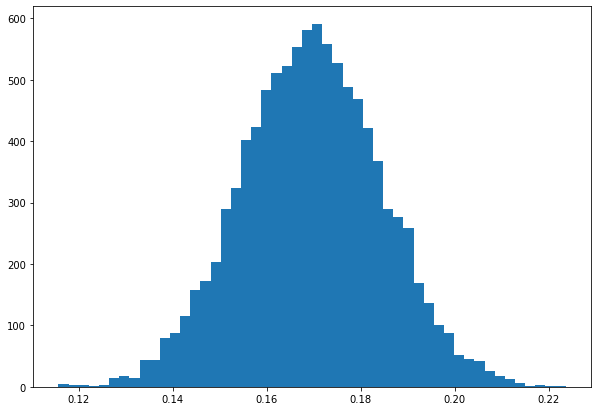

In [ ]:
# Number of iterations
N = 10000
# Sample Size
sN = 49

# Execute. Keep in mind it may take a while for the function to complete since it's going through a large number of iterations.
tl_mean_list = get_probability(int(time.time()), 0.02, 0.02, N, sN)

var = statistics.variance(tl_mean_list)

print('mean =',sum(tl_mean_list)/sN)
print('variance =',var)
print('sd =',sqrt(var))

fig, ax = plt.subplots(figsize = (10,7))
ax.hist(tl_mean_list, bins = 50)

plt.show()

## Credits

These works are created as a collaboration of the following people:

- [SurfChu85](https://twitter.com/SurfChu85)
- [Ayane Satomi](https://github.com/sr229)
- [Eyenine](https://twitter.com/Eyenine_i9)
- [KaidenFrizu](https://github.com/KaidenFrizu)